# CPVT Patients Demographics

- Clinical features
  - Heart structure abnormalities
  - Exercise induced PVT
  - Exercise induced syncope
  - Exercise induced sudden cardiac arrest
  - Abnormal ECG at rest
- Patient sex
- Inheritance pattern
- Family history of sudden cardiac death

In [2]:
from typing import Callable

import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from dataclasses import dataclass

from analysis.database import get_config, FigureParams
from analysis.write_report import PdfSection

sns.set_style("ticks")

In [3]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_08"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [4]:
# figure_3 = config.figure3
#
# colors = config.figure_palette

In [5]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
# use this for individual data to prevent duplicates
df_cpvt_individuals = df_cpvt.drop_duplicates(subset="individual_id")
num_cpvt_patients = f"Number of CPVT patients: {df_cpvt_individuals.shape[0]}"

In [7]:
# number of unique variants
print(df_cpvt["sequence_variant_id"].nunique())
# number of protein HGVS strings (should be less since cdna will sometimes map to same amino acid)
df_cpvt["p_hgvs_string"].nunique()

281


272

In [8]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)


def add_bar_label(curr_ax: plt.Axes, panel: FigureParams):
    for container in curr_ax.containers:
        curr_ax.bar_label(
            container,
            fmt="n=%g",
            fontsize=panel.text_fontsize,
        )

    # adjust y axis
    y_min, y_max = curr_ax.get_ylim()
    curr_ax.set_ylim(y_min, (y_max - y_min) * 0.075 + y_max)


def remap_values(df_input: pd.DataFrame, column: str, mapping: dict, *,
                 num_total_samples: int, map_fn: Callable = None,
                 count_col: str = "count"):
    df_input[column] = df_input[column].apply(
        lambda x: mapping.get(map_fn(x), x) if map_fn else mapping.get(x, x)
    )
    df_input["percentage"] = df_input[count_col].apply(
        lambda x: x / num_total_samples * 100
    ).round(2)

    order_cats = list(mapping.values())
    palette = {
        x_axis: color for x_axis, color in
        zip(order_cats, sns.color_palette(colors.cat_palette, len(order_cats)))
    }

    return order_cats, palette


## Clinical features


In [9]:
df_cpvt_individuals["Heart Structure Abnormality"].value_counts()

Heart Structure Abnormality
0.0    447
1.0     44
Name: count, dtype: int64

In [10]:
from analysis.database import set_figure_size

condition_info: dict[str, PdfSection] = {}


In [11]:
num_variants_per_patient = df_cpvt.groupby("individual_id").agg({
    "sequence_variant_id": "nunique",
}).groupby("sequence_variant_id").agg({
    "sequence_variant_id": "count"
})

num_variants_per_patient.columns = ["num_patients"]
num_variants_per_patient.reset_index(inplace=True)
num_variants_per_patient.columns = ["num_variants", "num_patients"]

num_variants_per_patient

,num_variants,num_patients
0,0,15
1,1,948
2,2,1


In [12]:
num_variants_per_patient["num_patients"].sum()

964

In [13]:
condition_info["CPVT Patients Information"] = PdfSection(
    section="CPVT Patients Information",
    stuff=[
        f"There are {df_cpvt["individual_id"].nunique()} in the dataset",
        f"Patients with CPVT, but invalid variant: {num_variants_per_patient[num_variants_per_patient["num_variants"] == 0]["num_patients"].iloc[0]}",
        f"Patients with 1 variant: {num_variants_per_patient[num_variants_per_patient["num_variants"] == 1]["num_patients"].iloc[0]}",
        f"Patients with more than 1 variant: {num_variants_per_patient[num_variants_per_patient["num_variants"] > 1]["num_patients"].iloc[0]}",
        f"Number of unique variants (transcript): {df_cpvt['c_hgvs_string'].nunique()}",
        f"Number of unique protein-coding variants: {df_cpvt['p_hgvs_string'].nunique()}"
    ]
)

## Family history of sudden cardiac death

In [14]:
bool(np.nan)

True

In [15]:
df_scd = df_cpvt_individuals[[
    "individual_id",
    "Sudden cardiac death::Mother",
    "Sudden cardiac death::Father",
    "Sudden cardiac death::num_family_members",
]].copy()
family_scd_col = "Family History of SCD"


def has_scd(row):
    if pd.isna(row["Sudden cardiac death::Mother"]) and pd.isna(
            row["Sudden cardiac death::Father"]) and pd.isna(
        row["Sudden cardiac death::num_family_members"]):
        return np.nan

    mother = row["Sudden cardiac death::Mother"] == 1
    father = row["Sudden cardiac death::Father"] == 1
    num_family_members = row["Sudden cardiac death::num_family_members"] > 0

    return mother or father or num_family_members


df_scd[family_scd_col] = df_scd.apply(
    has_scd,
    axis=1
)
df_scd.head()

,individual_id,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members,Family History of SCD
0,1,1.0,0.0,NaN,True
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,0.0,False
4,5,NaN,NaN,NaN,NaN


# Plot all the plots

In [16]:
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import SubplotSpec


def plot_counts_df(df_cat_inputs: pd.DataFrame,
                   column: str,
                   panel: str,
                   *,
                   plt_figure: plt.Figure,
                   suplot_spec: SubplotSpec,
                   map_fn: Callable = None,
                   section_title: str,
                   counting_title: str,
                   label: str
                   ):
    """
    Args:
        df_cat_inputs: Pandas dataframe with a column of categorical values or boolean values
        column: Column name to count
        panel: The name of the panel in figure 3 to use
        map_fn: Function to map the values to a different value
        section_title: Title of the section in the PDF
        counting_title: What is being counted
        plt_figure: The figure to plot on
        subplot_idx: The index of the subplot to plot on
    """

    # create the df with [colname, count]
    df_counted = pd.DataFrame(
        df_cat_inputs[column].value_counts()).reset_index()
    # renames the values for plotting, loops through the values to create a palette
    # adds a percentage column
    cat_list, count_pallette = remap_values(
        df_counted,
        column,
        figure_3.panels[panel].xticklabels,
        num_total_samples=df_counted["count"].sum(),
        map_fn=map_fn
    )

    condition_info[panel] = PdfSection(
        section=section_title,
        stuff=[
            f"Num total {counting_title} {df_counted['count'].sum()}",
            df_counted
        ]
    )
    curr_panel = figure_3.panels[panel]

    # fig = plt.figure(figsize=figure_3.fig_size)

    curr_ax = plt_figure.add_subplot(
        suplot_spec
    )

    sns.barplot(
        data=df_counted,
        x=column,
        y="count",
        hue=column,
        legend=False,
        edgecolor="black",
        palette=sns.color_palette(colors.cat_palette, len(cat_list)),
        order=cat_list,
        hue_order=cat_list,
        ax=curr_ax
    )
    add_bar_label(curr_ax, curr_panel)
    set_figure_size(
        curr_panel
    )

    # Add label in the upper left-hand corner within the panel's figure size
    # Add label directly above the y-label
    # Get the position of the y-label
    # x_pos, y_pos = curr_ax.yaxis.label.get_position()
    #
    # print(f"X position of the y-label: {x_pos}")
    # print(f"Y position of the y-label: {y_pos}")
    #
    # # Add label directly above the y-label
    # curr_ax.text(
    #     0, 1.05, label,
    #     transform=curr_ax.transAxes,
    #     fontsize=12,
    #     fontweight='bold',
    #     # va='bottom',
    #     # ha='left'
    # )



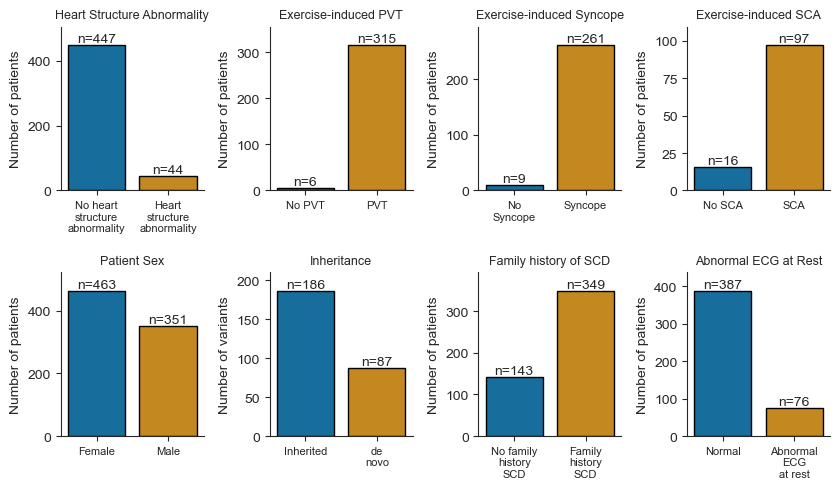

In [17]:
from matplotlib.gridspec import GridSpec


@dataclass
class Figure3Panel:
    column: str
    panel: str
    df_plt: pd.DataFrame
    section_title: str | None = None
    counting_title: str = "patients"


conditions_to_graph = [
    Figure3Panel(
        column="Heart Structure Abnormality",
        panel="panel_a",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Exercise/stress induced polymorphic ventricular tachycardia",
        panel="panel_b",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Syncope exercise/stress induced",
        panel="panel_c",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Exercise/stress induced sudden cardiac arrest",
        panel="panel_d",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="sex",
        panel="panel_e",
        df_plt=df_cpvt_individuals,
        section_title="Patient Sex"
    ),
    Figure3Panel(
        df_plt=df_cpvt,
        column="inheritance",
        panel="panel_f",
        counting_title="variants",
        section_title="Inheritance"
    ),
    Figure3Panel(
        column=family_scd_col,
        panel="panel_g",
        df_plt=df_scd,
        section_title="Family History of SCD",
    ),
    Figure3Panel(
        column="Baseline/resting electrocardiogram abnormality",
        panel="panel_h",
        df_plt=df_cpvt_individuals,
    ),
]

sns.set_style("ticks")

figure_3 = get_config().figure3
colors = get_config().figure_palette

fig = plt.figure(figsize=figure_3.fig_size)
n_row = 2
n_col = 4
gs = GridSpec(n_row, n_col, figure=fig)

for i, fig_info in enumerate(conditions_to_graph):
    curr_row = i // n_col
    curr_col = i % n_col

    label = f"{chr(65 + i)}"  # Generate labels A-A, A-B, A-C, etc.

    plot_counts_df(
        fig_info.df_plt,
        fig_info.column,
        fig_info.panel,
        section_title=fig_info.section_title if fig_info.section_title else fig_info.column,
        counting_title=fig_info.counting_title,
        plt_figure=fig,
        suplot_spec=gs[curr_row, curr_col],
        label=label
    )

fig.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Add horizontal/vertical space
save_current_plot("figure_3")
plt.show()

## Write information to PDF

In [18]:
from analysis.write_report import write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# report
pdf_name = figures_dir / "cpvt_demographics.pdf"

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, list(condition_info.values()))
c.save()

print(f"PDF saved to {pdf_name}")

PDF saved to ../figures/0_3_3/analysis_08/cpvt_demographics.pdf
